# Board Game Review Predictions

This notebook explores a dataset of board game reviews to try and build a predictor for average rating. I explore linear regression and random forest models as well as some feature engineering. 

In [114]:
#import libraries and data
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
board_games = pd.read_csv('games.csv')
board_games.shape

(81312, 20)

In [115]:
board_games=board_games.dropna(axis=0)
print(board_games.shape)
#filter out games with no ratings
board_games=board_games[board_games['users_rated']>0]
print(board_games.shape)
board_games.head()

(81268, 20)
(56894, 20)


,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


### Plot the average rating data to see the distribution. 
It looks roughly normal, but with some negative skew.

1.5788299348332662
6.016112849333889


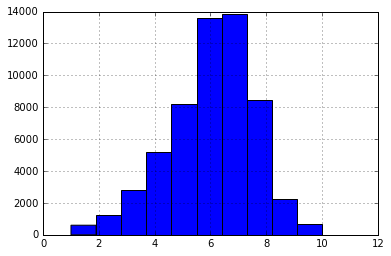

In [116]:
board_games['average_rating'].hist()
print(board_games['average_rating'].std())
print(board_games['average_rating'].mean())

### Check if there are any natural patterns in the data
It looks like the games are mostly similar, but there are a few outlier games that get a lot of players and are ranked higly. 

In [117]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)
numeric_columns = board_games.iloc[:,3:]
km.fit(numeric_columns)
labels=km.labels_
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

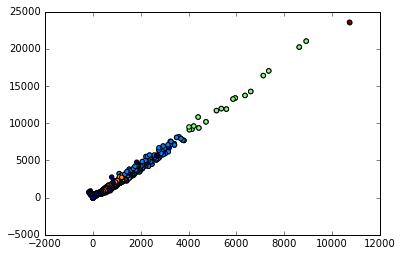

In [118]:
import numpy as np
game_mean=numeric_columns.mean(axis=1)
game_std=numeric_columns.std(axis=1)
plt.scatter(c=labels,x=game_mean,y=game_std)
plt.show()

### Check out correlation of columns

There seems to be some kind of ageism in the survey. Notice minage and year published have significant correlation with the average rating. Perhaps ther is some nostalgia affect or the reviewers are mainly in a certain age group and therefore rate games with a higher minage more favorably. 

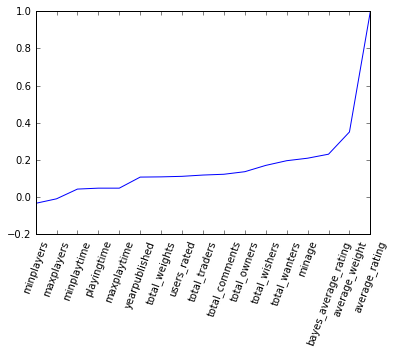

In [119]:
correlations = numeric_columns.corr()['average_rating'].sort_values()
correlations.plot()
plt.xticks(np.arange(len(correlations)),correlations.index, rotation=70)
plt.show()
#correlations

### Linear Regression

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
reg = LinearRegression()
kf = KFold(len(board_games),5,True)
features = ['average_weight','minage','total_wishers','total_comments','users_rated',
 'total_wanters', 'total_owners', 'total_traders', 'total_weights','yearpublished',
 'maxplaytime','playingtime','maxplayers','minplayers'] 
mse = np.mean(cross_val_score(reg,board_games[features],board_games['average_rating'],'mean_squared_error',kf))
print('MSE='+str(mse))
r2 = np.mean(cross_val_score(reg,board_games[features],board_games['average_rating'],'r2',kf))
print('R^2='+str(r2))

MSE=-2.10426741372
R^2=0.155759021522


MSE is pretty high compared to std deviation. This is not a good prediction. The next step is to try some feature engineering and also try different algorithms apart from linear regression. 

R^2 is only ~4%, which doesn't explain much of the variability. A better model and/or better features are required.

### How does low correlation feature removal affect r^2?
It seems that more features are beneficial.

In [121]:
features = ['average_weight','minage']
r2 = np.mean(cross_val_score(reg,board_games[features],board_games['average_rating'],'r2',kf))
print('R^2='+str(r2))

R^2=0.138316913498


### What about creating a composite feature?

These features don't seem to help explain an additional variance over those in the dataset.

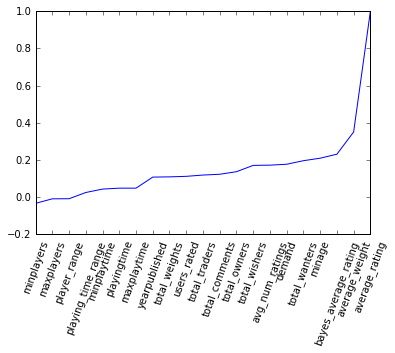

In [122]:
board_games['demand'] = board_games['total_wanters']+board_games['total_wishers']
board_games['player_range'] = board_games['maxplayers']-board_games['minplayers']
board_games['avg_num_ratings'] = board_games['total_owners']/board_games['users_rated']
board_games['playing_time_range'] = board_games['maxplaytime']-board_games['minplaytime']
numeric_columns = board_games.iloc[:,3:]
correlations = numeric_columns.corr()['average_rating'].sort_values()
correlations.plot()
plt.xticks(np.arange(len(correlations)),correlations.index, rotation=70)
plt.show()

In [123]:
kf = KFold(len(board_games),5,True)
features = ['average_weight','minage','total_wishers','total_comments','users_rated',
 'total_wanters', 'total_owners', 'total_traders', 'total_weights','yearpublished',
 'maxplaytime','playingtime','maxplayers','minplayers'] 
mse = np.mean(cross_val_score(reg,board_games[features],board_games['average_rating'],'mean_squared_error',kf))
print('MSE='+str(mse))
r2 = np.mean(cross_val_score(reg,board_games[features],board_games['average_rating'],'r2',kf))
print('R^2='+str(r2))

MSE=-2.09530189066
R^2=0.15929928213


### What about trying a random forest model?
Random forest is clearly a better estimator than linear regression, buy at R^2 of 35% it's still not very good. Most likely additional features are needed to make a better predictor for the board game average rating.

In [124]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
kf = KFold(len(board_games),5,True)
features = ['average_weight','minage','total_wishers','total_comments','users_rated',
 'total_wanters', 'total_owners', 'total_traders', 'total_weights','yearpublished',
 'maxplaytime','playingtime','maxplayers','minplayers'] 
mse = np.mean(cross_val_score(reg,board_games[features],board_games['average_rating'],'mean_squared_error',kf))
print('MSE='+str(mse))
r2 = np.mean(cross_val_score(reg,board_games[features],board_games['average_rating'],'r2',kf))
print('R^2='+str(r2))

MSE=-1.62979086785
R^2=0.348139981201
